# Face Aging Using Conditional GAN with PyTorch

Based on paper ["Face Aging With Conditional Generative Adversarial Networks"](https://arxiv.org/abs/1702.01983)

# Downloading the dataset

In [37]:
import math
import os
import time
from datetime import datetime
from pathlib import Path
from glob import glob

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils

%matplotlib inline

from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings('ignore')

# Prepare Data

In [38]:
def calc_age(taken, dob):
    '''
    Calculate age
    :param taken: Date when photo taken
    :param dob: Date of birth in serials
    :return: age in years
    '''
    birth = datetime.fromordinal(max(int(dob) - 366, 1))

    # assume the photo was taken in the middle of the year
    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

In [39]:
def load_data(dataset='imdb', data_dir='/kaggle/input/imdb-wiki-faces-dataset/imdb_crop'):
    '''
    Load meta data and calculate age
    :param dataset: dataset name, defaults = 'wiki'
    :param data_dir: data directory, defaults = './wiki_crop'
    :return: list of full_path and age
    '''
    # Load meta data
    meta_path = Path(data_dir) / f'{dataset}.mat'
    meta = loadmat(meta_path)
    meta_data = meta[dataset][0, 0]

    # Load all file paths
    full_path = meta_data['full_path'][0]
    full_path = [y for x in full_path for y in x]

    # Load dates of birth
    dob = meta_data['dob'][0]

    # Load years when photo taken
    photo_taken = meta_data['photo_taken'][0]

    # Calculate age
    age = [calc_age(photo_taken[i], dob[i]) for i in range(len(dob))]
    
    # Clean mapping with age > 0
    clean_mapping = {pth:age for (pth, age) in zip(full_path, age) if age > 0}
    
    # List of full_path, age
    full_path = list(clean_mapping.keys())
    age = list(clean_mapping.values())

    return full_path, age

In [40]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [41]:
# helper one-hot function
bins = [18, 29, 39, 49, 59]
def one_hot(x, bins):
    '''
    Convert tensor x to one-hot tensor
    '''
    x = x.numpy()
    idxs = np.digitize(x, bins, right=True)
    idxs = idxs.reshape(-1,1)
    z = torch.zeros(len(x), len(bins)+1).scatter_(1, torch.tensor(idxs), 1)
    return z

# Data Loader

In [42]:
class ImageAgeDataset(Dataset):
    '''Image and corresponding age Dataset'''
    def __init__(self, dataset, data_dir, transform=None):
        '''
        :param dataset: Dataset name.
        :param data_dir: Directory with all the images.
        :param transform: Optional transform to be applied on sample
        '''
        self.data_dir = data_dir
        self.full_path, self.age = load_data(dataset, data_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.age)
    
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.data_dir, self.full_path[idx]))
        age = self.age[idx]
        sample = {'image': image, 'age': age}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [43]:
class Resize(object):
    '''Resize the input PIL Image to the given size.'''
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.Resize(self.output_size)(image)
        return {'image': image, 'age': age}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.ToTensor()(image)
        # expand dept from 1 to 3 channels for gray images
        if image.size()[0] == 1:
            image = image.expand(3,-1,-1)
        return {'image': image, 'age': age}

In [44]:
dataset='imdb'
data_dir='/kaggle/input/imdb-wiki-faces-dataset/imdb_crop'
bins = [18, 29, 39, 49, 59]
img_size = 64
batch_size = 256
#num_workers = 0

tfms = transforms.Compose([Resize((img_size, img_size)),
                           ToTensor()])

train_dataset = ImageAgeDataset(dataset, data_dir, transform=tfms)


In [45]:
import random
total_samples = len(train_dataset)
num_samples_to_extract = 10000

# Get a random subset of indices
random_indices = random.sample(range(total_samples), num_samples_to_extract)

# Create a new DataLoader with the randomly sampled data
random_sampled_data = [train_dataset[i] for i in random_indices]
# build DataLoaders
train_loader = DataLoader(dataset=random_sampled_data, batch_size=batch_size)

In [46]:
len(train_loader)

40

In [47]:
# next(iter(train_loader))

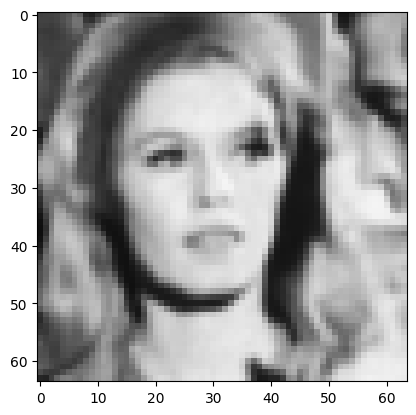

In [48]:
plt.imshow(train_dataset[69]['image'].numpy().transpose(1,2,0))

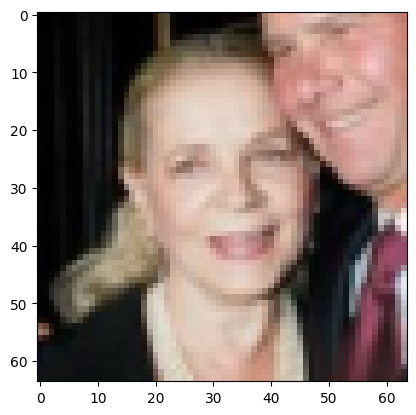

In [49]:
plt.imshow(train_dataset[42]['image'].numpy().transpose(1,2,0))

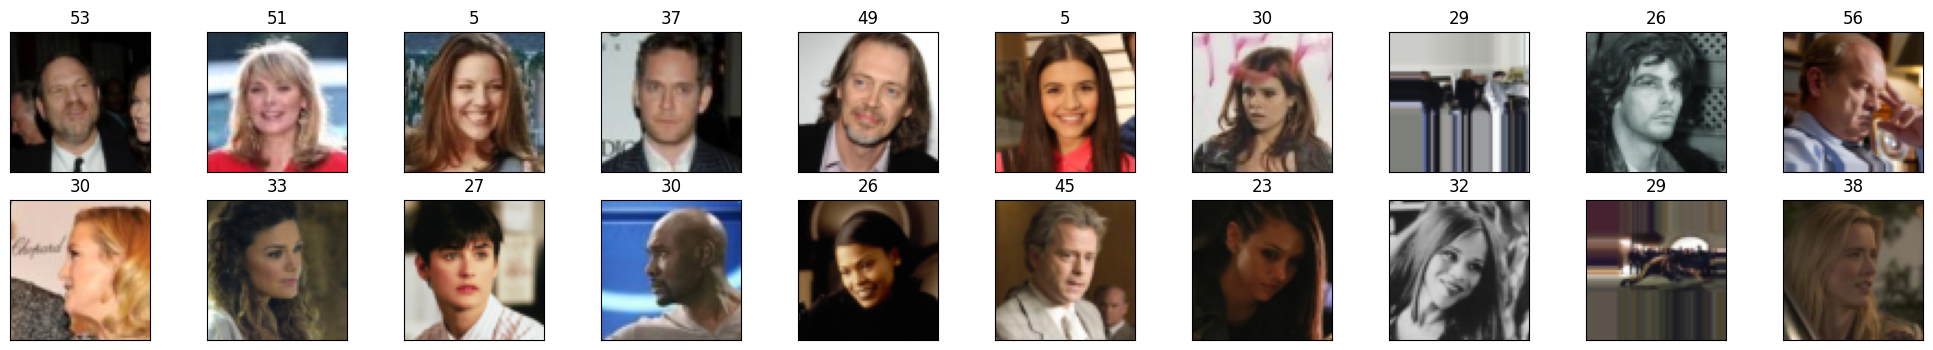

In [50]:
# obtain one batch of training images
dataiter = iter(train_loader)
data = next(dataiter)
images, labels = data['image'], data['age']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# Define Models

## Discriminator

In [51]:
import torch.nn as nn
import torch.nn.functional as F

In [52]:
# Helpers
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    
    if batch_norm:
        bn = nn.BatchNorm2d(out_channels)
        layers.append(bn)
        
    return nn.Sequential(*layers)

In [53]:
class Discriminator(nn.Module):
    
    def __init__(self, y_size, conv_dim=64):
        '''
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        :param y_size: The number of conditions 
        '''
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.y_size = y_size
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim+y_size, conv_dim * 2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.conv5 = conv(conv_dim*8, 1, 4, 1, 0, batch_norm=False)
            
    def forward(self, x, y):
        '''
        Forward propagation of the neural network
        :param x: The input scaled image x
        :param y: One-hot encoding condition tensor y (N,y_size)
        :return: Discriminator logits; the output of the neural network
        '''
        x = F.relu(self.conv1(x))
        y = y.view(-1,y.size()[-1],1,1)
        y = y.expand(-1,-1,x.size()[-2], x.size()[-1])
        x = torch.cat([x, y], 1)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        
        return x

## Generator

In [54]:
# Helpers
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    
    layers = []
    t_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(t_conv)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [55]:
class Generator(nn.Module):
    
    def __init__(self, z_size, y_size, conv_dim=64):
        '''
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        '''
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        # self.fc = nn.Linear(z_size+y_size, conv_dim*8*4*4)
        self.t_conv1 = deconv(z_size+y_size, conv_dim*8, 4, 1, 0)
        self.t_conv2 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv3 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv4 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv5 = deconv(conv_dim, 3, 4, batch_norm=False)
        
    def forward(self, z, y):
        '''
        Forward propagation of the neural network
        :param x: The input to the neural network
        :param y: The input condition to the neural network, Tensor (N,y_size)
        :return: A 64x64x3 Tensor image as output
        '''
        x = torch.cat([z, y], dim=1)
        x = x.view(-1, x.size()[-1], 1, 1)
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        x = self.t_conv5(x)
        x = torch.tanh(x)
        
        return x

## Build complete network

In [56]:
# define hyperparams
conv_dim = 64
z_size = 100
y_size = 6 # no. of age classes

# define discriminator and generator
D = Discriminator(y_size, conv_dim)
G = Generator(z_size, y_size, conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(70, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

Generator(
  (t_conv1): Sequential(
    (0): ConvTranspose2d(106, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05,

## Discriminator and Generator Losses

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [58]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    labels = labels.to(device)
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [59]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Training

In [60]:
def checkpoint(G, D, epoch, model, root_dir):
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    G_path = os.path.join(target_dir, f'G_{epoch}.pkl')
    D_path = os.path.join(target_dir, f'D_{epoch}.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

def oh_to_class(fixed_y):
    age_map = {0:'0-18',1:'19-29',2:'30-39',3:'40-49',4:'50-59',5:'60+'}
    if torch.cuda.is_available():
        fixed_y = fixed_y.cpu()
    fixed_y_idxs = fixed_y.numpy().nonzero()[1]
    fixed_y_ages = [age_map[idx] for idx in fixed_y_idxs]
    
    return fixed_y_ages

def save_samples_ages(samples, fixed_y, model, root_dir):
    fixed_y_ages = oh_to_class(fixed_y)
    samples_ages = {'samples': samples, 'ages': fixed_y_ages}
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    with open(f'{target_dir}/train_samples_ages.pkl', 'wb') as f:
        pkl.dump(samples_ages, f)

In [61]:
%%time
# import tqdm.tqdm_notebook as tqdm
import pickle as pkl

root_dir = '/content/Age-cGAN'
model = 'GAN_1'
os.makedirs(root_dir, exist_ok=True)

# move models to GPU, if available
G.to(device)
D.to(device)


# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 10

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_y = np.random.randint(len(bins), size=sample_size)
fixed_y = fixed_y.reshape(-1,1)
fixed_y = torch.zeros(sample_size, len(bins)+1).scatter_(1, torch.tensor(fixed_y), 1)

# train the network
for epoch in tqdm(range(num_epochs)):
    batch_i = 0
    for batch in tqdm(train_loader):
                
        batch_size = batch['image'].size(0)
        
        # important rescaling image step
        real_images = scale(batch['image'])
        
        # one-hot age
        ages = one_hot(batch['age'], bins)

        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        
        # Compute the discriminator losses on real images
        real_images = real_images.to(device)
        ages = ages.to(device)
        
        D_real = D(real_images, ages)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        z = z.to(device)
        #if train_on_gpu:
        #    z = z.cuda()
        fake_images = G(z, ages)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images, ages)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        fake_images = G(z, ages)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images, ages)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

        batch_i += 1
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    fixed_z = fixed_z.to(device)
    fixed_y = fixed_y.to(device)
    samples_z = G(fixed_z, fixed_y)
    samples.append(samples_z)
    G.train() # back to training mode
    
    # Save checkpoint
    checkpoint(G, D, epoch, model, root_dir)


# Save training generator samples
save_samples_ages(samples, fixed_y, model, root_dir)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [    1/   50] | d_loss: 1.4010 | g_loss: 2.6064
Epoch [    1/   50] | d_loss: 0.2565 | g_loss: 5.2607
Epoch [    1/   50] | d_loss: 0.3655 | g_loss: 10.8634
Epoch [    1/   50] | d_loss: 0.0965 | g_loss: 12.0960


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [    2/   50] | d_loss: 0.0699 | g_loss: 5.0128
Epoch [    2/   50] | d_loss: 0.5869 | g_loss: 8.0790
Epoch [    2/   50] | d_loss: 0.2194 | g_loss: 6.3023
Epoch [    2/   50] | d_loss: 0.5361 | g_loss: 3.6591


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [    3/   50] | d_loss: 1.8678 | g_loss: 4.6240
Epoch [    3/   50] | d_loss: 0.8320 | g_loss: 1.8512
Epoch [    3/   50] | d_loss: 0.7108 | g_loss: 1.9280
Epoch [    3/   50] | d_loss: 0.7444 | g_loss: 3.9006


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [    4/   50] | d_loss: 2.3274 | g_loss: 2.6950
Epoch [    4/   50] | d_loss: 0.5906 | g_loss: 2.7667
Epoch [    4/   50] | d_loss: 0.3466 | g_loss: 3.4236
Epoch [    4/   50] | d_loss: 0.7194 | g_loss: 2.9817


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [    5/   50] | d_loss: 0.8130 | g_loss: 2.0716
Epoch [    5/   50] | d_loss: 0.5530 | g_loss: 3.3589
Epoch [    5/   50] | d_loss: 0.7674 | g_loss: 2.3047
Epoch [    5/   50] | d_loss: 0.7842 | g_loss: 3.2458


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [    6/   50] | d_loss: 0.6765 | g_loss: 4.7867
Epoch [    6/   50] | d_loss: 0.7353 | g_loss: 2.1734
Epoch [    6/   50] | d_loss: 0.4117 | g_loss: 2.9474
Epoch [    6/   50] | d_loss: 0.6745 | g_loss: 2.1402


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [    7/   50] | d_loss: 0.8260 | g_loss: 3.1900
Epoch [    7/   50] | d_loss: 0.8623 | g_loss: 1.5874
Epoch [    7/   50] | d_loss: 0.7395 | g_loss: 4.2106
Epoch [    7/   50] | d_loss: 0.6178 | g_loss: 2.3888


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [    8/   50] | d_loss: 1.4555 | g_loss: 6.3627
Epoch [    8/   50] | d_loss: 0.6931 | g_loss: 2.5758
Epoch [    8/   50] | d_loss: 0.6320 | g_loss: 1.6950
Epoch [    8/   50] | d_loss: 0.7005 | g_loss: 2.9467


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [    9/   50] | d_loss: 0.8499 | g_loss: 1.3539
Epoch [    9/   50] | d_loss: 0.6605 | g_loss: 1.7511
Epoch [    9/   50] | d_loss: 0.4828 | g_loss: 2.0947
Epoch [    9/   50] | d_loss: 0.6060 | g_loss: 3.6817


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   10/   50] | d_loss: 0.5677 | g_loss: 2.4426
Epoch [   10/   50] | d_loss: 0.5650 | g_loss: 2.4175
Epoch [   10/   50] | d_loss: 0.6069 | g_loss: 3.4492
Epoch [   10/   50] | d_loss: 0.6406 | g_loss: 2.4398


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   11/   50] | d_loss: 0.9966 | g_loss: 4.4247
Epoch [   11/   50] | d_loss: 0.5087 | g_loss: 3.5859
Epoch [   11/   50] | d_loss: 0.4684 | g_loss: 2.4394
Epoch [   11/   50] | d_loss: 0.8136 | g_loss: 5.8709


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   12/   50] | d_loss: 2.0296 | g_loss: 1.6102
Epoch [   12/   50] | d_loss: 0.4144 | g_loss: 2.9766
Epoch [   12/   50] | d_loss: 0.6113 | g_loss: 2.6961
Epoch [   12/   50] | d_loss: 0.5217 | g_loss: 3.1972


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   13/   50] | d_loss: 1.0390 | g_loss: 4.2181
Epoch [   13/   50] | d_loss: 0.4741 | g_loss: 2.9621
Epoch [   13/   50] | d_loss: 0.5104 | g_loss: 2.4592
Epoch [   13/   50] | d_loss: 0.5300 | g_loss: 4.0974


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   14/   50] | d_loss: 0.7638 | g_loss: 1.8831
Epoch [   14/   50] | d_loss: 0.5069 | g_loss: 3.0185
Epoch [   14/   50] | d_loss: 0.7385 | g_loss: 5.0298
Epoch [   14/   50] | d_loss: 0.4825 | g_loss: 3.1311


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   15/   50] | d_loss: 0.5822 | g_loss: 4.8186
Epoch [   15/   50] | d_loss: 0.8924 | g_loss: 1.9865
Epoch [   15/   50] | d_loss: 0.4448 | g_loss: 2.7588
Epoch [   15/   50] | d_loss: 0.3923 | g_loss: 3.0611


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   16/   50] | d_loss: 0.4951 | g_loss: 3.6028
Epoch [   16/   50] | d_loss: 0.7261 | g_loss: 3.1802
Epoch [   16/   50] | d_loss: 0.2604 | g_loss: 1.9859
Epoch [   16/   50] | d_loss: 0.3191 | g_loss: 2.8670


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   17/   50] | d_loss: 0.5258 | g_loss: 2.6160
Epoch [   17/   50] | d_loss: 0.3769 | g_loss: 3.0015
Epoch [   17/   50] | d_loss: 0.4390 | g_loss: 3.1354
Epoch [   17/   50] | d_loss: 0.5243 | g_loss: 4.5336


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   18/   50] | d_loss: 0.8769 | g_loss: 2.6774
Epoch [   18/   50] | d_loss: 0.4658 | g_loss: 2.9460
Epoch [   18/   50] | d_loss: 0.5163 | g_loss: 3.4759
Epoch [   18/   50] | d_loss: 0.5263 | g_loss: 2.0512


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   19/   50] | d_loss: 0.4967 | g_loss: 1.8586
Epoch [   19/   50] | d_loss: 0.5213 | g_loss: 3.5854
Epoch [   19/   50] | d_loss: 0.8107 | g_loss: 6.7196
Epoch [   19/   50] | d_loss: 0.5250 | g_loss: 3.3986


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   20/   50] | d_loss: 1.2004 | g_loss: 2.5294
Epoch [   20/   50] | d_loss: 0.3582 | g_loss: 3.7940
Epoch [   20/   50] | d_loss: 0.9040 | g_loss: 4.3175
Epoch [   20/   50] | d_loss: 0.4796 | g_loss: 2.4047


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   21/   50] | d_loss: 0.5575 | g_loss: 1.4523
Epoch [   21/   50] | d_loss: 0.4088 | g_loss: 3.4836
Epoch [   21/   50] | d_loss: 0.6256 | g_loss: 1.7335
Epoch [   21/   50] | d_loss: 1.1713 | g_loss: 6.5060


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   22/   50] | d_loss: 0.4954 | g_loss: 2.0643
Epoch [   22/   50] | d_loss: 0.4573 | g_loss: 3.9009
Epoch [   22/   50] | d_loss: 0.2839 | g_loss: 2.8329
Epoch [   22/   50] | d_loss: 0.4747 | g_loss: 2.6448


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   23/   50] | d_loss: 0.6069 | g_loss: 1.2935
Epoch [   23/   50] | d_loss: 0.4179 | g_loss: 2.6065
Epoch [   23/   50] | d_loss: 0.3803 | g_loss: 3.7035
Epoch [   23/   50] | d_loss: 0.4251 | g_loss: 2.1423


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   24/   50] | d_loss: 0.9221 | g_loss: 0.6017
Epoch [   24/   50] | d_loss: 0.4348 | g_loss: 2.7362
Epoch [   24/   50] | d_loss: 0.3712 | g_loss: 3.0897
Epoch [   24/   50] | d_loss: 0.3825 | g_loss: 3.6871


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   25/   50] | d_loss: 0.4729 | g_loss: 2.2239
Epoch [   25/   50] | d_loss: 0.2957 | g_loss: 3.1081
Epoch [   25/   50] | d_loss: 0.3940 | g_loss: 4.4073
Epoch [   25/   50] | d_loss: 0.4076 | g_loss: 3.5766


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   26/   50] | d_loss: 0.8874 | g_loss: 1.9177
Epoch [   26/   50] | d_loss: 0.4679 | g_loss: 4.0068
Epoch [   26/   50] | d_loss: 0.3576 | g_loss: 2.7982
Epoch [   26/   50] | d_loss: 0.4218 | g_loss: 3.0812


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   27/   50] | d_loss: 0.3315 | g_loss: 3.0268
Epoch [   27/   50] | d_loss: 0.4723 | g_loss: 3.4688
Epoch [   27/   50] | d_loss: 0.4078 | g_loss: 3.1110
Epoch [   27/   50] | d_loss: 0.3770 | g_loss: 3.8843


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   28/   50] | d_loss: 0.4883 | g_loss: 1.1118
Epoch [   28/   50] | d_loss: 0.5703 | g_loss: 4.0409
Epoch [   28/   50] | d_loss: 0.8279 | g_loss: 3.8126
Epoch [   28/   50] | d_loss: 0.3966 | g_loss: 3.2029


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   29/   50] | d_loss: 0.5540 | g_loss: 2.4061
Epoch [   29/   50] | d_loss: 0.3833 | g_loss: 3.0212
Epoch [   29/   50] | d_loss: 0.3561 | g_loss: 4.3444
Epoch [   29/   50] | d_loss: 0.4011 | g_loss: 3.8228


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   30/   50] | d_loss: 0.2900 | g_loss: 3.0875
Epoch [   30/   50] | d_loss: 0.3266 | g_loss: 4.0029
Epoch [   30/   50] | d_loss: 0.3978 | g_loss: 2.4079
Epoch [   30/   50] | d_loss: 0.4120 | g_loss: 3.6896


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   31/   50] | d_loss: 0.3722 | g_loss: 2.7504
Epoch [   31/   50] | d_loss: 0.4640 | g_loss: 4.1646
Epoch [   31/   50] | d_loss: 0.5614 | g_loss: 5.0558
Epoch [   31/   50] | d_loss: 0.3022 | g_loss: 3.2161


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   32/   50] | d_loss: 0.3249 | g_loss: 3.0227
Epoch [   32/   50] | d_loss: 0.2679 | g_loss: 3.6517
Epoch [   32/   50] | d_loss: 0.8285 | g_loss: 3.0482
Epoch [   32/   50] | d_loss: 0.4469 | g_loss: 3.1780


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   33/   50] | d_loss: 0.4093 | g_loss: 3.0636
Epoch [   33/   50] | d_loss: 0.3965 | g_loss: 3.4866
Epoch [   33/   50] | d_loss: 0.2600 | g_loss: 3.2822
Epoch [   33/   50] | d_loss: 0.9379 | g_loss: 1.5989


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   34/   50] | d_loss: 0.6069 | g_loss: 1.3356
Epoch [   34/   50] | d_loss: 0.3966 | g_loss: 3.6234
Epoch [   34/   50] | d_loss: 0.5117 | g_loss: 2.0074
Epoch [   34/   50] | d_loss: 0.2740 | g_loss: 2.9137


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   35/   50] | d_loss: 0.4373 | g_loss: 1.3894
Epoch [   35/   50] | d_loss: 0.4345 | g_loss: 5.0492
Epoch [   35/   50] | d_loss: 2.3201 | g_loss: 1.6486
Epoch [   35/   50] | d_loss: 0.4210 | g_loss: 3.5582


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   36/   50] | d_loss: 0.5731 | g_loss: 1.7245
Epoch [   36/   50] | d_loss: 0.4243 | g_loss: 3.8033
Epoch [   36/   50] | d_loss: 0.2927 | g_loss: 3.2668
Epoch [   36/   50] | d_loss: 0.3058 | g_loss: 2.3579


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   37/   50] | d_loss: 0.4356 | g_loss: 2.3454
Epoch [   37/   50] | d_loss: 0.3888 | g_loss: 4.5289
Epoch [   37/   50] | d_loss: 0.2880 | g_loss: 2.5369
Epoch [   37/   50] | d_loss: 0.2413 | g_loss: 3.4571


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   38/   50] | d_loss: 0.7668 | g_loss: 5.1887
Epoch [   38/   50] | d_loss: 0.4584 | g_loss: 2.4144
Epoch [   38/   50] | d_loss: 0.4027 | g_loss: 3.4555
Epoch [   38/   50] | d_loss: 0.5226 | g_loss: 3.5139


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   39/   50] | d_loss: 3.1989 | g_loss: 1.3671
Epoch [   39/   50] | d_loss: 0.4270 | g_loss: 3.7108
Epoch [   39/   50] | d_loss: 0.3456 | g_loss: 3.4756
Epoch [   39/   50] | d_loss: 0.2423 | g_loss: 3.4247


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   40/   50] | d_loss: 0.9563 | g_loss: 0.5352
Epoch [   40/   50] | d_loss: 0.3538 | g_loss: 3.3292
Epoch [   40/   50] | d_loss: 0.3648 | g_loss: 3.7762
Epoch [   40/   50] | d_loss: 0.3365 | g_loss: 2.5400


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   41/   50] | d_loss: 3.8393 | g_loss: 1.6175
Epoch [   41/   50] | d_loss: 0.4021 | g_loss: 4.0176
Epoch [   41/   50] | d_loss: 0.2615 | g_loss: 2.7537
Epoch [   41/   50] | d_loss: 0.3263 | g_loss: 2.2707


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   42/   50] | d_loss: 0.2895 | g_loss: 3.2765
Epoch [   42/   50] | d_loss: 0.2487 | g_loss: 3.3944
Epoch [   42/   50] | d_loss: 0.2815 | g_loss: 2.6356
Epoch [   42/   50] | d_loss: 0.3509 | g_loss: 2.8765


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   43/   50] | d_loss: 1.3064 | g_loss: 1.4524
Epoch [   43/   50] | d_loss: 0.3184 | g_loss: 3.1843
Epoch [   43/   50] | d_loss: 1.8997 | g_loss: 3.0538
Epoch [   43/   50] | d_loss: 0.2841 | g_loss: 3.1040


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   44/   50] | d_loss: 0.4888 | g_loss: 2.5312
Epoch [   44/   50] | d_loss: 0.3501 | g_loss: 4.8442
Epoch [   44/   50] | d_loss: 0.4190 | g_loss: 3.0530
Epoch [   44/   50] | d_loss: 0.3752 | g_loss: 2.3842


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   45/   50] | d_loss: 0.4752 | g_loss: 1.7339
Epoch [   45/   50] | d_loss: 0.1968 | g_loss: 4.1579
Epoch [   45/   50] | d_loss: 0.2337 | g_loss: 3.8678
Epoch [   45/   50] | d_loss: 0.5423 | g_loss: 3.6458


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   46/   50] | d_loss: 0.3364 | g_loss: 2.5739
Epoch [   46/   50] | d_loss: 0.3477 | g_loss: 3.2869
Epoch [   46/   50] | d_loss: 0.1886 | g_loss: 5.0692
Epoch [   46/   50] | d_loss: 0.2995 | g_loss: 2.7401


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   47/   50] | d_loss: 0.3446 | g_loss: 2.4079
Epoch [   47/   50] | d_loss: 0.3105 | g_loss: 2.6019
Epoch [   47/   50] | d_loss: 0.7275 | g_loss: 7.1957
Epoch [   47/   50] | d_loss: 0.2833 | g_loss: 3.7886


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   48/   50] | d_loss: 0.3766 | g_loss: 2.4517
Epoch [   48/   50] | d_loss: 0.2343 | g_loss: 3.6073
Epoch [   48/   50] | d_loss: 0.3697 | g_loss: 2.7354
Epoch [   48/   50] | d_loss: 0.2199 | g_loss: 2.5361


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   49/   50] | d_loss: 0.2271 | g_loss: 3.5299
Epoch [   49/   50] | d_loss: 0.2122 | g_loss: 3.8559
Epoch [   49/   50] | d_loss: 1.2739 | g_loss: 1.9434
Epoch [   49/   50] | d_loss: 0.5020 | g_loss: 3.9083


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [   50/   50] | d_loss: 0.2295 | g_loss: 3.3049
Epoch [   50/   50] | d_loss: 0.2680 | g_loss: 3.4852
Epoch [   50/   50] | d_loss: 0.1986 | g_loss: 4.2592
Epoch [   50/   50] | d_loss: 0.5742 | g_loss: 2.0004
CPU times: user 7min 7s, sys: 2.62 s, total: 7min 9s
Wall time: 6min 36s


## Training loss

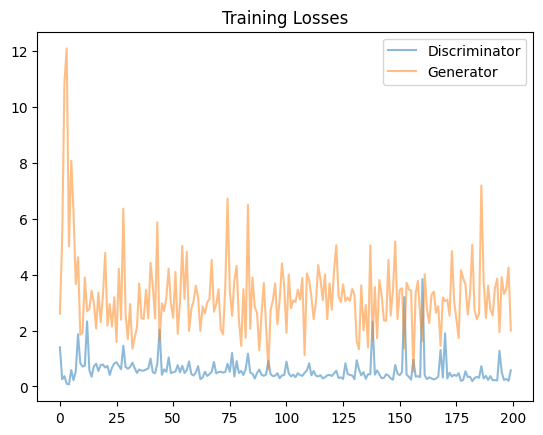

In [62]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

In [63]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples, ages):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img, age in zip(axes.flatten(), samples[epoch], ages):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(age)
        im = ax.imshow(img.reshape((64,64,3)))

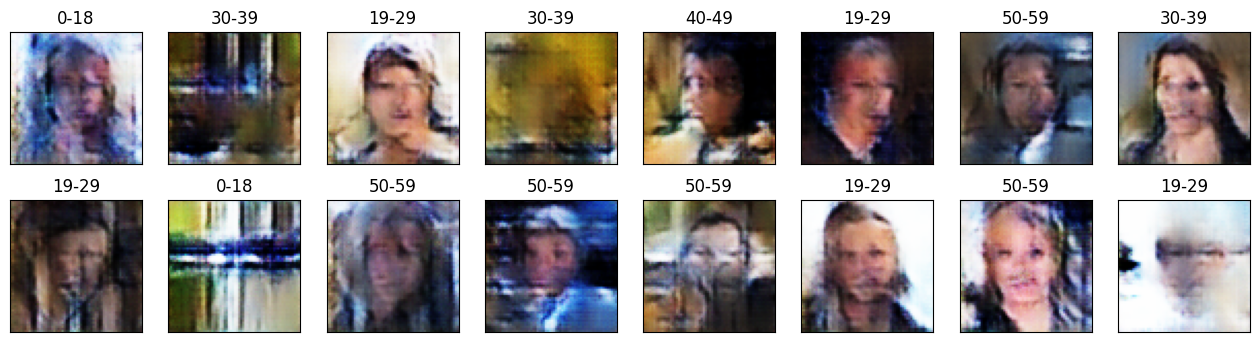

In [64]:
fixed_y_ages = oh_to_class(fixed_y)
_ = view_samples(-1, samples, fixed_y_ages)